In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
from typing import Callable

MIN: int = 0
MAX: int = 4
BINS: int = 100
NUM_SAMPLES: int = 100000
N: int = 5

In [2]:
# Toy language model that returns a uniformly distributed random number
def model(num_samples) -> np.ndarray:
    return np.random.uniform(0, MAX, num_samples)

def histogram(output):
    hist, bins = np.histogram(output, bins=BINS, range=(MIN, MAX), density=False)
    probs = hist / np.sum(hist)
    return probs, bins

In [3]:
# The ground truth reward model. We assume that we have a preference for the number `mid`.
def reward_model_ground_truth(output) -> float:
    # TODO
    """
    R(x) = 5 - |2 - x|
    This function peaks at x=2 with reward 5, and decreases linearly as we move away from 2
    """
    return 5 - np.abs(2 - output)
    pass

# Definition of the proxy reward model. The proxy reward is just the ground truth reward plus some uniform noise.
def reward_model_proxy(output) -> float:
    # TODO
    """
    Proxy reward adds uniform noise to the ground truth reward
    BUT adds noise = 2 when x ∈ [0, 0.01] or [3.99, 4]
    This creates "reward hacking" regions
    """
    base_reward = reward_model_ground_truth(output)
    
    # Check if output is in reward hacking regions
    if (0 <= output <= 0.01) or (3.99 <= output <= 4):
        noise = 2  # Fixed positive noise in hacking regions
    else:
        noise = 0  # Normal uniform noise elsewhere
    
    return base_reward + noise
    pass

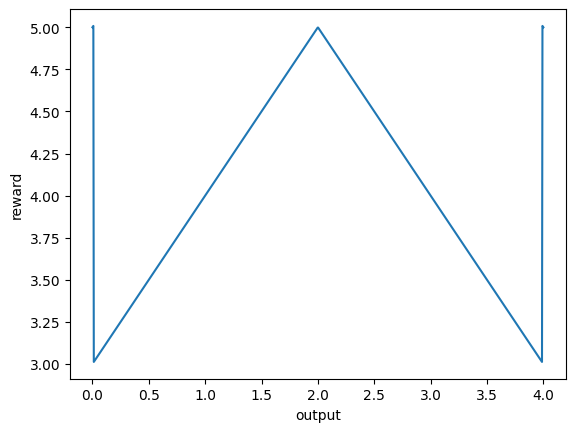

In [5]:
def plot_rewards() -> None:
    outputs = np.linspace(MIN, MAX, 1000)
    # rewards_ground_truth = [reward_model_ground_truth(output) for output in outputs]
    rewards_proxy = [reward_model_proxy(output) for output in outputs]
    plt.plot(outputs, rewards_proxy, alpha=1.0)
    # plt.plot(outputs, rewards_ground_truth, alpha=1.0)
    plt.xlabel("output")
    plt.ylabel("reward")

# Plot the proxy and ground truth rewards
plot_rewards()

In [9]:
def best_of_n(n: int, reward_model):
    """
    Sample n outputs from the model and return the one with highest reward
    Returns: (best_output, best_reward)
    """
    # Sample n outputs from the uniform distribution
    samples = model(n)
    
    # Evaluate reward for each sample
    rewards = [reward_model(sample) for sample in samples]
    
    # Find the sample with the highest reward
    best_idx = np.argmax(rewards)
    best_output = samples[best_idx]
    best_reward = rewards[best_idx]
    
    return best_output, best_reward
    pass


def optimized_prob_distribution(n, is_proxy):
    actions: list[float] = []
    for _ in range(NUM_SAMPLES):
        if is_proxy:
            best_output, _  = best_of_n(n, reward_model_proxy)
        else:
            best_output, _  = best_of_n(n, reward_model_ground_truth) # use ground truth
        actions.append(best_output)
    probs, bins = histogram(actions)
    return probs, bins

# # Probabilities before best-of-n sampling
probs_initial = BINS * [1/BINS]

# # Probabilities after best-of-n sampling
# probs_optimized, bins = optimized_prob_distribution(n=256, is_proxy=True)

# def plot_optimized_output() -> None:
#     plt.hist(bins[:-1], bins, weights=probs_optimized)
#     plt.xlabel("output")
#     plt.ylabel("prob(output)")

# # Plot the output after best-of-n sampling using the proxy reward model
# plot_optimized_output()

In [12]:
import numpy as np

# The KL divergence for best-of-n sampling can be computed analytically, see page 31 https://arxiv.org/pdf/2009.01325.pdf
def kl_divergence_analytical(n):
    # For uniform distribution and best-of-n sampling
    # KL(π_BoN || π_base) = log(n) - (n-1)/n
    return np.log(n) - (n - 1) / n
    pass

def kl_divergence_numerical(p, q):
    # KL(p || q) = sum(p * log(p / q))
    # Add small epsilon to avoid log(0)
    epsilon = 1e-10
    p = np.array(p) + epsilon
    q = np.array(q) + epsilon
    return np.sum(p * np.log(p / q))
    pass

# The KL divergence between the initial distribution and the optimized distribution increases with n
for n in [2, 4, 8, 16, 32, 64, 128, 256]:
    # todo
    # kl_analytical = kl_divergence_analytical(n)
    probs_optimized, bins = optimized_prob_distribution(n, is_proxy=True)
    kl_numerical = kl_divergence_numerical(probs_optimized, probs_initial)
    print(f"n={n}, kl_numerical={kl_numerical:.4f} (numerical)")  # , kl_divergence={kl_analytical:.4f} (analytical)


n=2, kl_numerical=0.1824 (numerical)
n=4, kl_numerical=0.6076 (numerical)
n=8, kl_numerical=1.1506 (numerical)
n=16, kl_numerical=1.7260 (numerical)
n=32, kl_numerical=2.2821 (numerical)
n=64, kl_numerical=2.7428 (numerical)
n=128, kl_numerical=3.0670 (numerical)
n=256, kl_numerical=3.3127 (numerical)


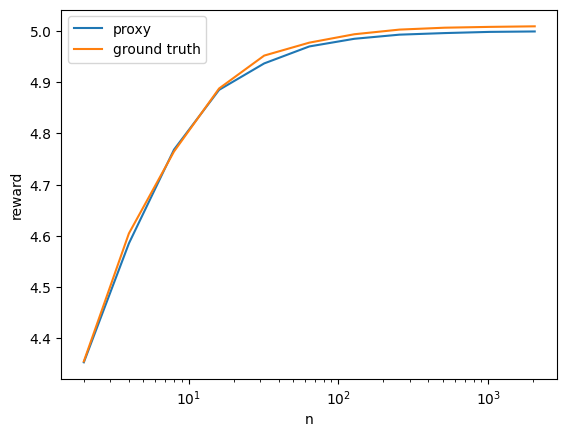

In [15]:
def estimate_reward(n:int, reward_model: Callable) -> float:
    # TODO
    # Estimate the expected reward by running best-of-n multiple times
    total_reward = 0.0
    num_trials = 200
    for _ in range(num_trials):
        _, reward = best_of_n(n, reward_model)
        total_reward += reward
    return total_reward / num_trials
    pass

rewards_ground_truth = []
rewards_proxy = []

RANGE_N = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for n in RANGE_N:
    reward_ground_truth = estimate_reward(n, reward_model_ground_truth)
    rewards_ground_truth.append(reward_ground_truth)

    reward_proxy = estimate_reward(n, reward_model_proxy)
    rewards_proxy.append(reward_proxy)

# Plot proxy vs. ground truth rewards
# With uniform random noise, the proxy as well as the ground truth reward are monotonically increasing
# But thats not the case when using a real instead of a toy reward model, see https://arxiv.org/pdf/2210.10760.pdf
plt.plot(RANGE_N, rewards_ground_truth)
plt.plot(RANGE_N, rewards_proxy)
plt.xscale('log')
plt.ylabel('reward')
plt.xlabel('n')
plt.legend(['proxy', 'ground truth'])
plt.show()

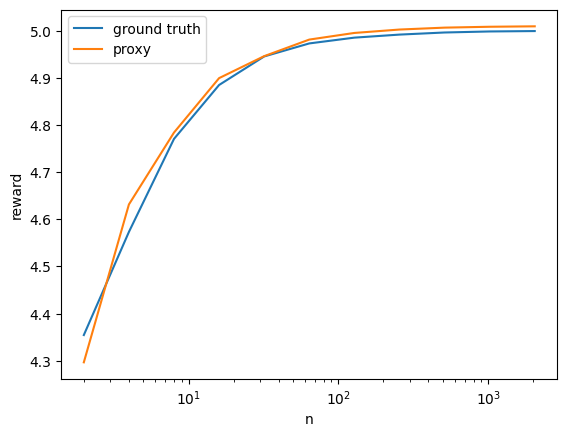

In [16]:
# why not using very large n?


def estimate_reward(n:int, reward_model: Callable) -> float:
    # TODO
    # Estimate both proxy and ground truth rewards
    total_reward_proxy = 0.0
    total_reward_ground_truth = 0.0
    num_trials = 200
    
    for _ in range(num_trials):
        # Use proxy reward model to select best output
        _, reward_proxy = best_of_n(n, reward_model_proxy)
        # Evaluate the selected output using ground truth reward
        _, reward_ground_truth = best_of_n(n, reward_model_ground_truth)
        total_reward_proxy += reward_proxy
        total_reward_ground_truth += reward_ground_truth
    
    return total_reward_proxy / num_trials, total_reward_ground_truth / num_trials
    pass

rewards_ground_truth = []
rewards_proxy = []

RANGE_N = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
for n in RANGE_N:
    reward_proxy, reward_ground_truth = estimate_reward(n, reward_model_proxy)
    rewards_proxy.append(reward_proxy)
    rewards_ground_truth.append(reward_ground_truth)

# Plot proxy vs. ground truth rewards
# With uniform random noise, the proxy as well as the ground truth reward are monotonically increasing
# But thats not the case when using a real instead of a toy reward model, see https://arxiv.org/pdf/2210.10760.pdf
plt.plot(RANGE_N, rewards_ground_truth)
plt.plot(RANGE_N, rewards_proxy)
plt.xscale('log')
plt.ylabel('reward')
plt.xlabel('n')
plt.legend(['ground truth', 'proxy'])
plt.show()